In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import ase.io

from aml_storage import Labels, Block, Descriptor

from utils.librascal import RascalSphericalExpansion
from utils.clebsh_gordan import ClebschGordanReal

This example demonstrates the iterative construction of atom-centered density correlations.
The calculations incorporate ideas from the N-body iterative contraction of equivariants [paper](https://doi.org/10.1063/5.0021116) and the optimal radial basis [paper](https://doi.org/10.1063/5.0057229).

# Covariance-optimal basis

We start by computing the spherical expansion representation for a set of methane structures. 

In [12]:
rascal_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 6,
    "max_angular": 6,
    "gaussian_sigma_type": "Constant",
    "compute_gradients": False # True,
}

nmax, lmax = rascal_hypers["max_radial"], rascal_hypers["max_angular"]
calculator = RascalSphericalExpansion(rascal_hypers)

In [13]:
frames = ase.io.read("./data/random-methane-10k.extxyz", "::1000")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [14]:
density_expansion = calculator.compute(frames)

Then, select the C,H block, which is the most significant for this dataset, and project to the optimal covariance basis.

In [15]:
# for each (C,H) block, construct the optimal covariance basis
opt_eve = {}
opt_eva = {}
full_norms = np.zeros(len(frames))
for index, block in density_expansion:
    if index["center_species"] == 6 and index["neighbor_species"] == 1:
        feats = block.values.reshape(-1, len(block.features))
        full_norms += (block.values**2).sum(axis=-1).sum(axis=-1)
        cov = feats.T @ feats / feats.shape[0]
        eva, eve = sp.linalg.eigh(cov)
        eva = eva[::-1]; eve = eve[:,::-1]
        opt_eva[index["spherical_harmonics_l"]] = eva
        opt_eve[index["spherical_harmonics_l"]] = eve

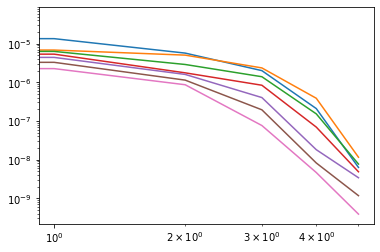

In [16]:
for l in range(lmax+1):
    plt.loglog(opt_eva[l])

Create compressed features, using labels naming consistent with Nigam 2020

In [17]:
sel_thresh = 1e-7
blocks = []
for l in range(lmax+1):
    n_selected = len(np.where(opt_eva[l] > sel_thresh)[0])    
    de_block = density_expansion.block(center_species = 6, neighbor_species=1, spherical_harmonics_l = l)
    block = Block(
        data = de_block.values@opt_eve[l][:,:n_selected],
        samples = de_block.samples,
        symmetric = Labels(["m"],np.asarray(range(-l,l+1), dtype=np.int32).reshape(-1,1)),
        features = Labels(["n", "multiplicity"], np.asarray([[n, 1] for n in range(n_selected)], dtype=np.int32))
    )
    if rascal_hypers["compute_gradients"]:
        de_grad = de_block.gradient("positions")
        block.add_gradient(
            name="positions",
            samples=de_grad[0],
            gradient=de_grad[1]@opt_eve[l][:,:n_selected],
        )
    blocks.append( block )                 
    

In [18]:
acdc_nu1 = Descriptor(sparse = Labels(names=["sigma", "lambda", "nu"], 
                                      values=np.asarray([[ 1, l, 1] for l in range(rascal_hypers["max_angular"]+1)], dtype=np.int32)), 
                      blocks = blocks
                     )

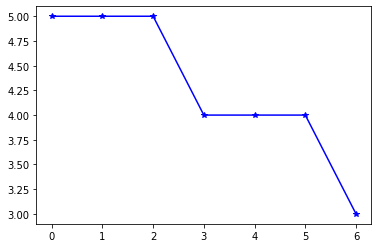

In [19]:
ln_nu1 = np.asarray([[s["lambda"], b.values.shape[-1]] for s,b in acdc_nu1 ])
plt.plot(ln_nu1[:,0], ln_nu1[:,1], 'b*-')

# ACDC utilities

In [20]:
def acdc_full_product_indices(x_a, x_b):
    """
    Enumerates the indices of features that result from a product of ACDC equivariants.
    Sparse indices should be labeled as ("sigma", "lambda", "nu"). 
    Dense feature names are not used, except for picking up the "multiplicity" of a feature set. 
    """
    
    # determines the cutoff in the new features
    lmax_a = max(x_a.sparse["lambda"])
    lmax_b = max(x_b.sparse["lambda"])
    lcut = lmax_a+lmax_b+1
    
    # assumes uniform nu
    nu_a = x_a.sparse["nu"][0]
    nu_b = x_b.sparse["nu"][0]
    
    # block indexes for the incremented features
    NU=nu_a+nu_b    
    X_list = {(S, L, NU):{} for L in range(lcut+1) for S in [-1,1]}
    for index_a, block_a in x_a:
        lambda_a = index_a["lambda"]        
        sigma_a = index_a["sigma"]
        for index_b, block_b in x_b:
            lambda_b = index_b["lambda"]
            sigma_b = index_b["sigma"]
            for f_a in block_a.features:
                w_a = f_a["multiplicity"]
                f_a = tuple(f_a)                
                for f_b in block_b.features:
                    w_b = f_b["multiplicity"]
                    f_b = tuple(f_b)
                    W = w_a*w_b
                    IDX = f_a[:-1]+(lambda_a,)+f_b[:-1]+(lambda_b,)
                    for L in range(np.abs(lambda_a-lambda_b), 1+min(lambda_a+lambda_b, lcut) ):
                        S = sigma_a*sigma_b*(-1)**(lambda_a+lambda_b+L)
                        X_list[(S,L,NU)][IDX] = W
    return X_list

In [21]:
def acdc_combine(x_a, x_b, selected_features=None, feature_names=None, clebsch_gordan=None):
    """
    Performs a CG product of two sets of equivariants. Only requirement is that 
    sparse indices are labeled as ("sigma", "lambda", "nu"). The automatically-determined
    naming of output features can be overridden by giving a list of "feature_names".
    A dictionary of select_features (organized in the same blocks as the sparse indices,
    each containing a dictionary of the feature indices and an associated multiplicity)
    can also be specified to filter the features that should be selected. 
    """
    
    # determines the cutoff in the new features
    lmax_a = max(x_a.sparse["lambda"])
    lmax_b = max(x_b.sparse["lambda"])
    lcut = lmax_a+lmax_b
    
    # creates a CG object, if needed
    if clebsch_gordan is None:
        clebsch_gordan = ClebschGordanReal(lcut)
    
    # assumes uniform nu in the descriptors
    nu_a = x_a.sparse["nu"][0]
    nu_b = x_b.sparse["nu"][0]
    
    # block indexes for the incremented features
    NU=nu_a+nu_b    
    X_blocks = {(S, L, NU): [] for L in range(lcut+1) for S in [-1,1]}
    X_idx = {(S, L, NU): [] for L in range(lcut+1) for S in [-1,1]}
    
    #NB : assumes the samples are matching. we could add some kind of validation, at least on size if not on content
    samples = x_a.block(0).samples
    nsamples = len(samples)
    try:
        grad_samples, _ = x_a.block(0).gradient("positions")
        X_grads = {(S, L, NU): [] for L in range(lcut+1) for S in [-1,1]}
    except:
        grad_samples = None
    
    # automatic generation of the output features names - "x1 x2 x3 ; x1 x2 -> x1_a x2_a x3_a k_nu x1_b x2_b l_nu"
    if feature_names is None:
        feature_names = tuple( n+"_a" for n in x_a.block(0).features.names[:-1]) + ("k_"+str(NU),) +tuple( n+"_b" for n in x_b.block(0).features.names[:-1] ) + ("l_"+str(NU),) +("multiplicity",)
    
    # loops over sparse blocks of x_a
    for index_a, block_a in x_a:
        lambda_a = index_a["lambda"]
        sigma_a = index_a["sigma"]
        # and x_b
        for index_b, block_b in x_b:
            lambda_b = index_b["lambda"]
            sigma_b = index_b["sigma"]
            #loops over all permissible output blocks. note that blocks will be filled from different la, lb
            for L in range(np.abs(lambda_a-lambda_b), 1+min(lambda_a+lambda_b, lcut) ):
                # determines parity of the block
                S = sigma_a*sigma_b*(-1)**(lambda_a+lambda_b+L)
                sel_feats = []
                sel_weights = []
                #determines the features that are in the select list
                for n_a in range(len(block_a.features)):
                    f_a = block_a.features[n_a]
                    w_a = f_a["multiplicity"]                    
                    f_a = tuple(f_a)[:-1] # discards multiplicity info
                    for n_b in range(len(block_b.features)):                    
                        f_b = block_b.features[n_b]
                        w_b = f_b["multiplicity"]
                        f_b = tuple(f_b)[:-1]
                        
                        # the index is assembled consistently with the scheme above
                        IDX = f_a + (lambda_a,) + f_b + (lambda_b,)
                        if selected_features is None: 
                            w_X = w_a*w_b
                        else:
                            if IDX in selected_features[(S,L,NU)]:
                                w_X = selected_features[(S,L,NU)][IDX]
                            else:
                                continue
                        sel_feats.append([n_a,n_b])
                        sel_weights.append(np.sqrt(w_X/(w_a*w_b)))
                        X_idx[(S,L,NU)].append(IDX+(w_X,))
                    
                sel_feats = np.asarray(sel_feats, dtype=int)
                
                if len(sel_feats) == 0:
                    continue

                # builds all products in one go
                one_shot_blocks = clebsch_gordan.combine_einsum(block_a.values[:,:,sel_feats[:,0]],
                                                         block_b.values[:,:,sel_feats[:,1]],
                                                         L, combination_string="iq,iq->iq" )
                # do gradients, if they are present...
                if grad_samples is not None:
                    smp_a, grad_a = block_a.gradient("positions")
                    smp_b, grad_b = block_b.gradient("positions")
                    one_shot_grads = ( clebsch_gordan.combine_einsum(
                                        block_a.values[smp_a['sample']][:,:,sel_feats[:,0]],
                                        grad_b[:,:,sel_feats[:,1]],
                                        L=L,combination_string="iq,iq->iq") +
                                    clebsch_gordan.combine_einsum(
                                        block_b.values[smp_b['sample']][:,:,sel_feats[:,1]],
                                        grad_a[:,:,sel_feats[:,0]],
                                        L=L,combination_string="iq,iq->iq")
                        )
                
                # now loop over the selected features to build the blocks
                for Q in range(len(sel_feats)):
                    #(n_a, n_b) = sel_feats[Q]
                    newblock = one_shot_blocks[:,:,Q]*sel_weights[Q]                    
                    X_blocks[(S,L,NU)].append(newblock)
                    if grad_samples is not None:
                        newgrad = one_shot_grads[:,:,Q]*sel_weights[Q]
                        X_grads[(S,L,NU)].append(newgrad)                        

    # turns data into sparse storage format (and dumps any empty block in the process)
    nz_idx = []
    nz_blk = []
    for SLN in X_blocks:
        S, L, NU = SLN
        # create blocks
        if (len(X_blocks[SLN])==0): continue  # skips empty blocks
        nz_idx.append(SLN)
        newblock= Block(
                        # feature index must be last
                        data=np.moveaxis(np.asarray(X_blocks[SLN]), 0, -1),
                        samples = samples,
                        symmetric = Labels(["mu"],np.asarray(range(-L,L+1), dtype=np.int32).reshape(-1,1)),
                        features = Labels( feature_names,
                                           np.asarray(X_idx[SLN],dtype=np.int32)
                                          )
                          ) 
        if grad_samples is not None:
            newblock.add_gradient("positions", grad_samples, np.moveaxis(np.asarray(X_grads[SLN]), 0, -1))
        nz_blk.append(newblock)
    X = Descriptor(Labels(["sigma", "lambda", "nu"], np.asarray(nz_idx, dtype=np.int32)), 
                            nz_blk)
    return X

In [22]:
def acdc_increment(x_nu, x_1, selected_features=None, clebsch_gordan=None):
    """ Specialized version of the CG product to perform iterations with nu=1 features"""
    nu = x_nu.sparse["nu"][0]
    if nu==1:
        feature_names = ("n_1", "l_1", "n_2", "l_2", "multiplicity")
    else:
        feature_names = tuple(x_nu.block(0).features.names[:-1]) + ("k_"+str(nu+1), "n_"+str(nu+1),"l_"+str(nu+1), "multiplicity")
    return acdc_combine(x_nu, x_1, feature_names = feature_names, selected_features = selected_features, clebsch_gordan=clebsch_gordan)

In [24]:
cg = ClebschGordanReal(lmax*3)

In [41]:
acdc_nu2 = acdc_increment(acdc_nu1, acdc_nu1, clebsch_gordan=cg)

In [42]:
acdc_nu3 = acdc_increment(acdc_nu2, acdc_nu1, clebsch_gordan = cg)

KeyboardInterrupt: 

## analyze jacobian

Requires `compute_gradients=True`

manually densify features

In [16]:
j_nu1 = []
for idx, block in acdc_nu1:
    smp, grad = block.gradient("positions")
    j_nu1.append(grad.reshape((grad.shape[0],-1)))
j_nu1 = np.concatenate(j_nu1, axis=-1).reshape(10,12,-1)    

In [17]:
j_nu2 = []
for idx, block in acdc_nu2:
    smp, grad = block.gradient("positions")
    j_nu2.append(grad.reshape((grad.shape[0],-1)))
j_nu2 = np.concatenate(j_nu2, axis=-1).reshape(10,12,-1)

In [24]:
j_nu3 = []
for idx, block in acdc_nu3:
    smp, grad = block.gradient("positions")
    j_nu3.append(grad.reshape((grad.shape[0],-1)))
j_nu3 = np.concatenate(j_nu3, axis=-1).reshape(10,12,-1)

sv_nu3 = np.asarray([ sp.linalg.svdvals(j_nu3[i])  for i in range(10)])

In [18]:
import scipy as sp

In [19]:
sv_nu1 = np.asarray([ sp.linalg.svdvals(j_nu1[i])  for i in range(10)])
sv_nu2 = np.asarray([ sp.linalg.svdvals(j_nu2[i])  for i in range(10)])

Text(0, 0.5, 'CN ($\\nu=2)$')

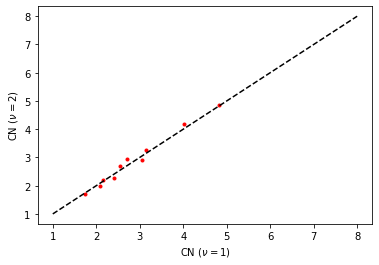

In [20]:
plt.plot(
    sv_nu1[:,0]/sv_nu1[:,-1],
    sv_nu2[:,0]/sv_nu2[:,-1],
    'r.'
)
plt.plot([1,8],[1,8],'k--')
plt.xlabel(r"CN ($\nu=1)$")
plt.ylabel(r"CN ($\nu=2)$")

Text(0, 0.5, 'CN ($\\nu=3)$')

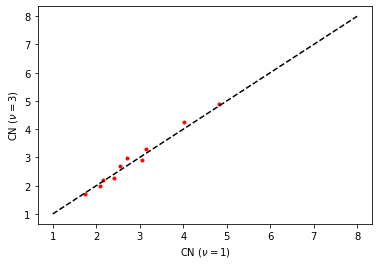

In [25]:
plt.plot(
    sv_nu1[:,0]/sv_nu1[:,-1],
    sv_nu3[:,0]/sv_nu3[:,-1],
    'r.'
)
plt.plot([1,8],[1,8],'k--')
plt.xlabel(r"CN ($\nu=1)$")
plt.ylabel(r"CN ($\nu=3)$")

# Independent feature tracking

In [30]:
def _get_idx_nl(nu, idx, names):  
    # extracts the n,l feature indices. assumes indices are labelled n_nu, l_nu
    nl_values = np.zeros((nu,2), dtype = np.int32)    
    for i, n in enumerate(names):
        w, k = n.split("_")
        k = int(k)
        if w == "n":
            nl_values[k-1][0] = idx[i]
        elif w == "l":
            nl_values[k-1][1] = idx[i]
    return nl_values

def _sort_idx_nl(nl_values):
    # sorts the n,l indices lexicographically (l first, then n)
    isort = np.lexsort(nl_values.T)
    return nl_values[isort]

In [47]:
def acdc_canonical_indices(x_nu, x_1, selected_features = None):
    """ Determines canonical (n,l, lexicographically sorted) indices. 
    This eliminates a large fraction of the linearly dependent equivariants. 
    Also tracks multiplicity so norm should be conserved. """
    
    nu = x_nu.sparse["nu"][0]
    if nu==1:
        names = ("n_1", "l_1", "n_2", "l_2")
    else:
        names = tuple(x_nu.block(0).features.names[:-1]) + ("k_"+str(nu+1), "n_"+str(nu+1),"l_"+str(nu+1))
    if selected_features is None:
        selected_features = acdc_full_product_indices(x_nu, x_1)
    
    X_list = {}
    for block in selected_features:
        canonical_idx = {}
        canonical_counts = {}
        if len(selected_features[block]) == 0:
            continue
        X_list[block] = {}        
        for idx in selected_features[block]:             
            # gets only the n,l part of the nu features 
            cidx = _get_idx_nl(nu+1, idx, names)
            # gets the sorted version
            sidx = _sort_idx_nl(cidx)
            # converts to tuple
            cidx = tuple(cidx.flatten())
            sidx = tuple(sidx.flatten())            
            # gets multiplicity (weight)
            W = selected_features[block][idx]
                
            if not sidx in canonical_counts:
                canonical_idx[sidx] = []
                canonical_counts[sidx] = 0
            
            canonical_counts[sidx] += W
            if cidx == sidx:
                canonical_idx[sidx].append(idx)
            
        X_list[block] = {}
        for nl in canonical_counts:            
            if (canonical_counts[nl]%len(canonical_idx[nl]) !=0):
                    print("non integer count!", canonical_counts[nl], len(canonical_idx[nl]))                
            for idx in canonical_idx[nl]:
                X_list[block][idx] = canonical_counts[nl]//len(canonical_idx[nl])        
    return X_list

In [39]:
sel_idx = acdc_canonical_indices(acdc_nu1, acdc_nu1)

In [43]:
canonical_acdc_nu2 = acdc_increment(acdc_nu1, acdc_nu1, clebsch_gordan=cg, selected_features=sel_idx)

In [48]:
sel_idx = acdc_canonical_indices(canonical_acdc_nu2, acdc_nu1)

In [49]:
canonical_acdc_nu3 = acdc_increment(canonical_acdc_nu2, acdc_nu1, clebsch_gordan=cg, 
                                    selected_features=sel_idx)

In [ ]:
sel_idx = acdc_canonical_indices(canonical_acdc_nu3, acdc_nu1)

In [ ]:
canonical_acdc_nu4 = acdc_increment(canonical_acdc_nu3, acdc_nu1, clebsch_gordan=cg, 
                                    selected_features=sel_idx)

In [53]:
nnu2_full = np.sum([ len(b.features) for i, b in acdc_nu2 ])
nnu2_can = np.sum([ len(b.features) for i, b in canonical_acdc_nu2 ])

In [59]:
norm_full2 = 0.0
for i, b in acdc_nu2:
    norm_full2 += (b.values**2).sum(axis=-1).sum(axis=-1)
norm_can2 = 0.0
for i, b in canonical_acdc_nu2:
    norm_can2 += (b.values**2).sum(axis=-1).sum(axis=-1)

In [65]:
print((nnu2_full, norm_full2.sum()), (nnu2_can, norm_can2.sum()))

(3758, 5.314165797736207e-06) (1975, 5.314165797736207e-06)


In [68]:
nnu3_full = np.sum([ len(b.features) for i, b in acdc_nu3 ])
nnu3_can = np.sum([ len(b.features) for i, b in canonical_acdc_nu3 ])

In [66]:
norm_full3 = 0.0
for i, b in acdc_nu3:
    norm_full3 += (b.values**2).sum(axis=-1).sum(axis=-1)
norm_can3 = 0.0
for i, b in canonical_acdc_nu3:
    norm_can3 += (b.values**2).sum(axis=-1).sum(axis=-1)

In [69]:
print((nnu3_full, norm_full3.sum()), (nnu3_can, norm_can3.sum()))

(591690, 4.039472232721673e-09) (112076, 4.0394722327216725e-09)


# Compute iterative schemes